In [1]:
! pip install -q accelerate peft bitsandbytes transformers trl wandb huggingface_hub ipywidgets

In [1]:
from huggingface_hub import notebook_login
import os
import wandb

wandb.login()
notebook_login()

wandb: Currently logged in as: kevinv3796. Use `wandb login --relogin` to force relogin


In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "deepseek-ai/deepseek-coder-1.3b-base"

# The instruction dataset to use
dataset_name = "ArtifactAI/arxiv_python_research_code"

# Fine-tuned model name
new_model = "deepseek-coder-1.3b-python-peft"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

We only select a small subset of the dataset because finetuning doesn't require a huge dataset, given that our model already has a certain understanding of whatever language we're training it on.

In [4]:
from datasets import load_dataset

dataset = load_dataset(dataset_name)

# Shuffle the dataset and slice it
#trying a smaller slice for hyperparam tuning
dataset = dataset['train'].shuffle(seed=42).select(range(1000))

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

In [5]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

#we use bitsandbytes to load the model in 4-bit. 
#This massively decreases its memory footprint and allows us to fine-train it on a free tier Colab notebook
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

Your GPU supports bfloat16: accelerate training with bf16=True


In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# run down to this cell on subsequent runs if restarting the kernel and continuing runs at the end of the notebook

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Evaluation of base model

In [18]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

def generate_output(input):
    # Run text generation pipeline with our next model
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
    result = pipe(input)
    print(result[0]['generated_text'])

In [20]:
prompt = """# Load a dataset using pandas
import pandas as pd
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
"""

generate_output(prompt)

# Load a dataset using pandas
import pandas as pd
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
data.head()

# Display the last few rows of the dataset
data.tail()

# Display the number of rows and columns in the dataset
data.shape

# Display the data types of each column
data.dtypes

# Display the summary statistics of the dataset
data.describe()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.isnull().sum()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.isnull().sum()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.isnull().sum()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.is


In [21]:
prompt = """# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a machine learning model (e.g., Random Forest)

"""

generate_output(prompt)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a machine learning model (e.g., Random Forest)

# Fit the model to the training data

# Make predictions on the test data

# Evaluate the model's performance

# Use the model to make predictions on new data
<jupyter_output>
<empty_output>



In [22]:
prompt = """# Define a convolutional neural network using PyTorch
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers (convolutional, pooling, fully connected)
    
    def forward(self, x):
        # Define the forward pass

# Instantiate the model and show its structure
"""

generate_output(prompt)

# Define a convolutional neural network using PyTorch
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers (convolutional, pooling, fully connected)
    
    def forward(self, x):
        # Define the forward pass

# Instantiate the model and show its structure
model = CNN()
print(model)
<jupyter_output>
<empty_output>



In [23]:
prompt = """# Preprocess text data for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = "This is a sample sentence for tokenization."
tokens = word_tokenize(text)

# Display the tokens

"""

generate_output(prompt)

# Preprocess text data for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = "This is a sample sentence for tokenization."
tokens = word_tokenize(text)

# Display the tokens

print(tokens)
<jupyter_output>
['This', 'is', 'a','sample','sentence', 'for', 'tokenization', '.']
<jupyter_text>
Stemming and Lemmatization
<jupyter_code>
# Import the necessary libraries
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Define the text
text = "This is a sample sentence for tokenization."

# Create a PorterStemmer object
stemmer = PorterStemmer()

# Stem the text
stemmed_text = stemmer.stem(text)

# Display the stemmed text
print(stemmed_text)

# Create a Word


In [24]:
prompt = """# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
"""

generate_output(prompt)

# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
title = soup.find('title').text
links = [link.get('href') for link in soup.find_all('a')]

# Print the extracted information
print(f'Title: {title}')
print(f'Links: {links}')

# Use Selenium to scrape a webpage
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Firefox()
driver.get('https://example.com')

# Wait for the page to load
wait = WebDriverWait(driver, 10)
wait.until(EC.presence


In [25]:
prompt = """# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
"""

generate_output(prompt)

# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
title = soup.find('title').text
links = [link.get('href') for link in soup.find_all('a')]

# Print the extracted information
print(f'Title: {title}')
print(f'Links: {links}')

# Use Selenium to scrape a webpage
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Firefox()
driver.get('https://example.com')

# Wait for the page to load
wait = WebDriverWait(driver, 10)
wait.until(EC.presence


In [26]:
prompt = """# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
"""

generate_output(prompt)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
dot_product = np.dot(A, B)

# Print the dot product
print(dot_product)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
dot_product = np.dot(A, B)

# Print the dot product
print(dot_product)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of


In [27]:
prompt = """# Create a 3D plot using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Display the 3D surface plot
"""

generate_output(prompt)

# Create a 3D plot using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Display the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='rainbow')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
<jupyter_output>
<empty_output>
<jupyter_text>
3.3.2.3.3.4.5.6.7.8.9.10.1


## Fine-tune model

In [28]:
os.environ["WANDB_PROJECT"] = "python-autocomplete-deepseek"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [29]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

{'loss': 0.7796, 'grad_norm': 0.030525265261530876, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.9035, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.8093, 'grad_norm': 0.036525554955005646, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.9395, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.8034, 'grad_norm': 0.04083041846752167, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.8616, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.7796, 'grad_norm': 0.04836655780673027, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.9909, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.8906, 'grad_norm': 0.039162393659353256, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.8593, 'grad_norm': 1.3608026504516602, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.8359, 'grad_norm': 0.03401603922247887, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.9379, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'ep

In [30]:
wandb.run.finish()

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▅▂▆▃▁▇▄▃▅▄▂▄▃▄▃▁▂▁▇▄▂▄▁▃▃▃▇█▄▄▃▂▃▂▆▂▃▄▃
total_flos,2.874581368209408e+16
train/epoch,1.0
train/global_step,1250
train/grad_norm,0.0
train/learning_rate,0.0002
train/loss,0.8478


### Hyperparam Tuning
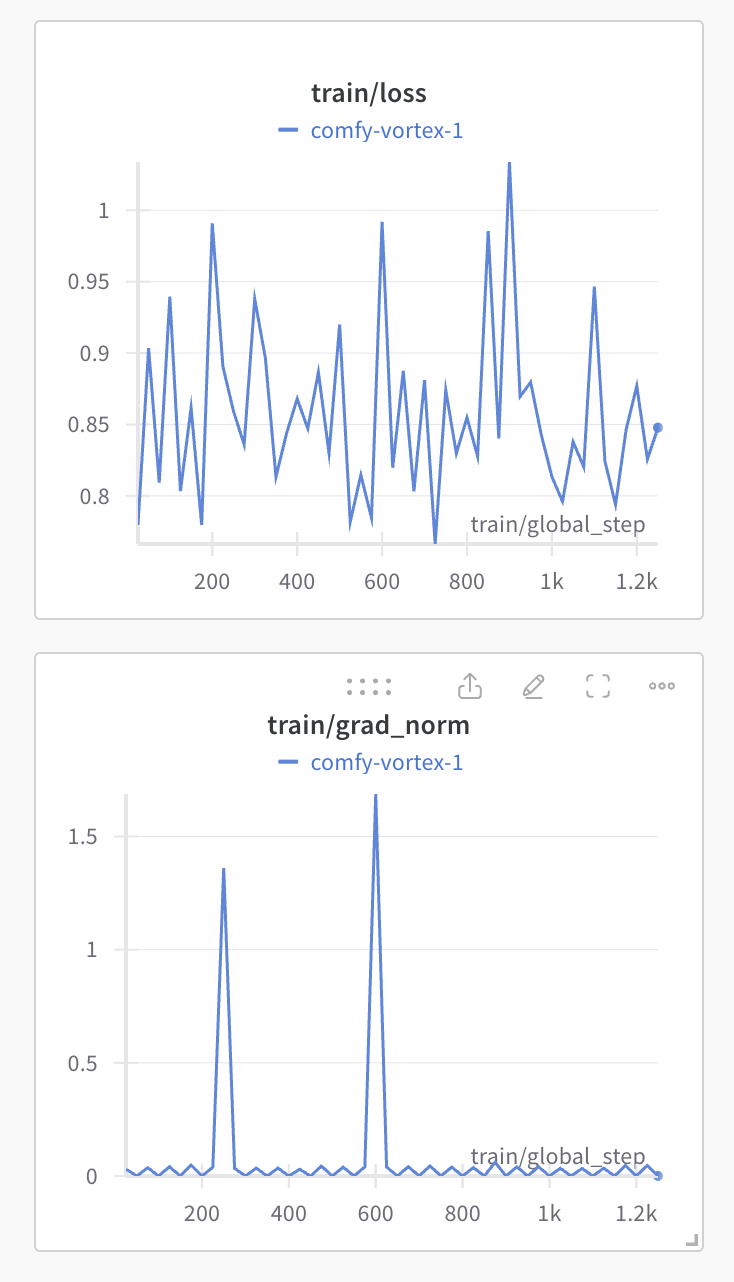

The training above was quite unstable, since we saw exploding and vanishing gradients. We might need to train with different hyperparams.

### Run 1: Learning Rate

In [31]:
# Initial learning rate (AdamW optimizer)
learning_rate = 5e-5

In [32]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [33]:
trainer.train()

{'loss': 0.7813, 'grad_norm': 0.022311056032776833, 'learning_rate': 5e-05, 'epoch': 0.02}
{'loss': 0.9155, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.04}
{'loss': 0.8129, 'grad_norm': 0.03203234449028969, 'learning_rate': 5e-05, 'epoch': 0.06}
{'loss': 0.9599, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.08}
{'loss': 0.8052, 'grad_norm': 0.04477047547698021, 'learning_rate': 5e-05, 'epoch': 0.1}
{'loss': 0.8883, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.12}
{'loss': 0.7807, 'grad_norm': 0.05843821540474892, 'learning_rate': 5e-05, 'epoch': 0.14}
{'loss': 1.0097, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.16}
{'loss': 0.8907, 'grad_norm': 0.04959563538432121, 'learning_rate': 5e-05, 'epoch': 0.18}
{'loss': 0.878, 'grad_norm': 1.9280540943145752, 'learning_rate': 5e-05, 'epoch': 0.2}
{'loss': 0.8375, 'grad_norm': 0.04590395465493202, 'learning_rate': 5e-05, 'epoch': 0.22}


KeyboardInterrupt: 

In [34]:
wandb.run.finish() #finish previous run

train/epoch,▁▂▂▃▄▄▅▆▇▇█
train/global_step,▁▂▂▃▄▅▅▆▇▇█
train/grad_norm,▁▁▁▁▁▁▁▁▁█▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▅▂▆▂▄▁█▄▄▃
train/epoch,0.22
train/global_step,275
train/grad_norm,0.0459
train/learning_rate,5e-05
train/loss,0.8375


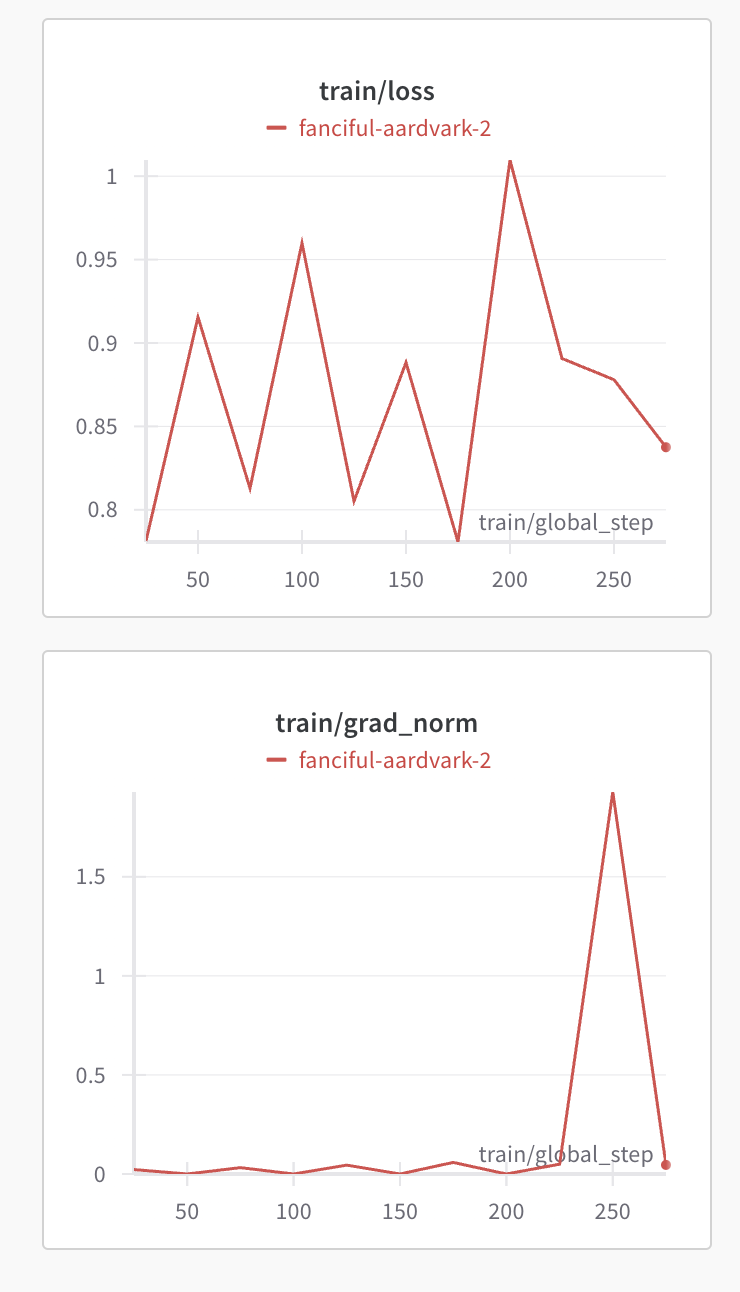

I interrupted the training since we were again seeing exploding and vanishing gradients. Let's try gradient clipping and accumulation.

### Run 2: Gradient clipping and accumulation
Let's try different values of gradient clipping

In [7]:
# Initial learning rate (AdamW optimizer)
learning_rate = 5e-4 #initial learning rate

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.1

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


KeyboardInterrupt: 

This way of carrying out sweeps is quite slow and cumbersome, let's try out a better way like Weights and Biases Sweeps

In [ ]:
%env WANDB_PROJECT=vit_snacks_sweeps
%env WANDB_LOG_MODEL=true

def model_init():
    model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    return model

In [ ]:
# method
sweep_config = {
    'method': 'random'
}


# hyperparameters
parameters_dict = {
    'per_device_train_batch_size': {
        'values': [4,8,16,32]
    },
    'max_grad_norm': {
        'values': [0.001, 0.01, 0.1]
    },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 2e-4
    },
    'weight_decay': {
        'values': [0.001, 0.01, 0.1]
    },
    'lr_scheduler_type':{
        'values': ['cosine', 'linear', 'constant']
    },
    'optim': {
        'values': ['paged_adamw_32bit', 'paged_lion_32bit', 'rmsprop_bnb_32bit']
    }
}


sweep_config['parameters'] = parameters_dict


In [ ]:
def train(config=None):
  with wandb.init(config=config):
    # Load LoRA configuration
    peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

    # Set training parameters
    training_arguments = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=config.per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        optim=config.optim,
        save_steps=save_steps,
        logging_steps=logging_steps,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        fp16=fp16,
        bf16=bf16,
        max_grad_norm=config.max_grad_norm,
        max_steps=max_steps,
        warmup_ratio=warmup_ratio,
        group_by_length=group_by_length,
        lr_scheduler_type=config.lr_scheduler_type,
        report_to="wandb"
    )

    # Set supervised fine-tuning parameters
    trainer = SFTTrainer(
        model=model,
        train_dataset=dataset,
        peft_config=peft_config,
        dataset_text_field="code",
        max_seq_length=max_seq_length,
        tokenizer=tokenizer,
        args=training_arguments,
        packing=packing,
    )

    trainer.train()

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='vit-snacks-sweeps')

In [ ]:
wandb.agent(sweep_id, train, count=20)

# Save Model

In [3]:
# Reload model in FP16 and merge it with LoRA weights - this needs to be done after restarting the kernel and loading the model again
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/MadMarx37/deepseek-coder-1.3b-python/commit/8062d6cf6da2b3d8742580e3ff666cd06b5b2e01', commit_message='Upload tokenizer', commit_description='', oid='8062d6cf6da2b3d8742580e3ff666cd06b5b2e01', pr_url=None, pr_revision=None, pr_num=None)